In [1]:
def readGraph(fileName: str) -> [[int]]:
	file = open(fileName, "r")
	
	[n, m] = [int(x) for x in file.readline().split()]
	graph = [[] for i in range(n)]
	for i in range(m):
		[u, v] = [int(x) for x in file.readline().split()]
		graph[u].append(v)
		graph[v].append(u)
	
	file.close()
	
	return graph

def getParts(graph: [[int]]) -> ([int], [int]):
	n = len(graph)
	part = [0 for u in range(n)]
	
	def dfs(u: int) -> None:
		for v in graph[u]:
			if part[v] == 0:
				part[v] = part[u] ^ 3
				dfs(v)
			elif not part[u] ^ part[v] == 3:
				raise Exception("Graph is not bipartite.")
	
	for u in range(n):
		if part[u] == 0:
			part[u] = 1
			dfs(u)
	
	result = ([], [])
	for u in range(n):
		if part[u] == 1:
			result[0].append(u)
		else:
			assert part[u] == 2
			result[1].append(u)
	return result

In [2]:
import queue

def HK(fileName: str) -> int:
	graph = readGraph(fileName)
	n = len(graph)
	(left, right) = getParts(graph)
	
	matched = [-1 for i in range(n)]
	
	while True:
		dist = [n + 1 for i in range(n)]
		def bfs() -> int:
			q = queue.Queue()
			
			for u in left:
				if matched[u] == -1:
					dist[u] = 0
					q.put(u)
			
			while not q.empty():
				u = q.get()
				for v in graph[u]:
					tmp = matched[v]
					if tmp == -1:
						return dist[u]
					elif dist[u] + 1 < dist[tmp]:
						dist[tmp] = dist[u] + 1
						q.put(tmp)
			
			return -1
		
		maxDist = bfs()
		if maxDist == -1:
			break
		
		def dfs(u: int) -> bool:
			for v in graph[u]:
				tmp = matched[v]
				if tmp == -1 or dist[tmp] == dist[u] + 1 and dfs(tmp):
					matched[u] = v
					matched[v] = u
					return True
			return False
		
		for u in left:
			if matched[u] == -1:
				dfs(u)
	
	result = 0
	for u in left:
		if matched[u] != -1:
			result += 1
	return result

In [3]:
def AlternativeToHK(fileName: str) -> int:
	graph = readGraph(fileName)
	n = len(graph)
	
	matched = [-1 for i in range(n)]
	
	any = True
	while any:
		any = False
		
		visited = [False for i in range(n)]
		def dfs(u: int) -> bool:
			visited[u] = True
			for v in graph[u]:
				if matched[v] == -1:
					matched[u] = v
					matched[v] = u
					return True
			for v in graph[u]:
				if not visited[matched[v]] and dfs(matched[v]):
					matched[u] = v
					matched[v] = u
					return True
			return False
		
		for i in range(n):
			if not visited[i] and matched[i] == -1 and dfs(i):
				any = True
	
	result = 0
	for i in range(n):
		if matched[i] != -1:
			result += 1
	assert result % 2 == 0
	return result // 2

In [4]:
from mip import Model, xsum, maximize

def LP(fileName: str, solverName: str) -> int:
	graph = readGraph(fileName)
	n = len(graph)
	(left, right) = getParts(graph)
	
	m = 0
	edgesIds = [[] for u in range(n)]
	for u in left:
		for v in graph[u]:
			edgesIds[u].append(m)
			edgesIds[v].append(m)
			m += 1
	
	model = Model(solver_name=solverName)
	
	x = [model.add_var() for u in range(m)]
	for i in range(m):
		model += x[i] >= 0
	for u in range(n):
		model += xsum(x[i] for i in edgesIds[u]) <= 1
	
	model.objective = maximize(xsum(x))
	
	model.optimize()
	
	if model.objective_value == None:
		return 0
	return int(model.objective_value)

def LPcbc(fileName: str) -> int:
	return LP(fileName, "CBC")

def LPgur(fileName: str) -> int:
	return LP(fileName, "GRB")

In [5]:
import random

def generateRandomGraph(n: int, p: float, fileName: str) -> None:
	random.seed(2137)
	
	edges = []
	for u in range(n):
		for v in range(n):
			if random.uniform(0.0, 1.0) <= p:
				edges.append((u, v + n))
	
	file = open(fileName, "w")
	file.write(f"{n * 2} {len(edges)}\n")
	for (u, v) in edges:
		file.write(f"{u} {v}\n")
	file.close()

Model has no variables. Nothing to optimize.
Model has no variables. Nothing to optimize.


Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-04
Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming problem using Primal Simplex

Coin0506I Presolve 478 (-981) rows, 860 (-24) columns and 1649 (-1003) elements
Clp1000I sum of infeasibilities 1.02116e-05 - average 2.13632e-08, 102 fixed columns
Coin0506I Presolve 449 (-29) rows, 728 (-132) columns and 1431 (-218) elements
Clp0029I End of values pass after 713 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000002 - largest nonzero change 2.8966481e-05 ( 0.001448324%) - largest zero change 2.9669812e-05
Clp0000I Optimal - objective value 244
Clp0000I Optimal - objective value 244
Coin0511I After Postsolve, objective 244, infeasibilities - dual 0 (0), primal 0 (0)
Clp0014I Perturbing problem by 0.001% of 1.0081802 - largest nonzero change 2.8010222e-05 ( 0.0014005111%) - largest zero change 2.9669812e-05
Clp0000I Optimal - ob

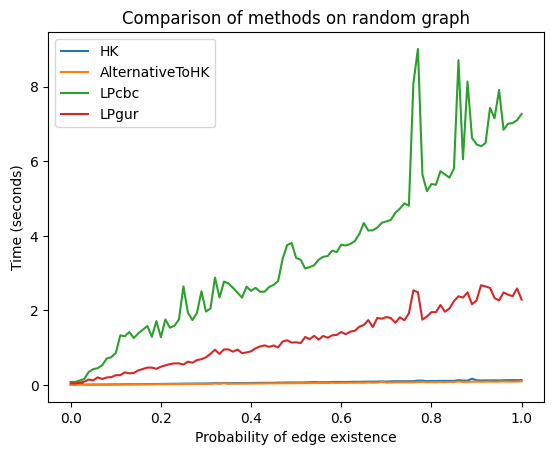

In [6]:
import time
import matplotlib.pyplot as plt

def compareMethodsRandom() -> None:
	n = 300
	
	xs = [i / 100 for i in range(101)]
	
	HKTimes = []
	AlternativeToHKTimes = []
	LPcbcTimes = []
	LPgurTimes = []
	
	for x in xs:
		generateRandomGraph(n, x, "input")
		
		start_time = time.time()
		HKResult = HK("input")
		end_time = time.time()
		HKTimes.append(end_time - start_time)
		
		start_time = time.time()
		AlternativeToHKResult = AlternativeToHK("input")
		end_time = time.time()
		AlternativeToHKTimes.append(end_time - start_time)
		
		start_time = time.time()
		LPcbcResult = LPcbc("input")
		end_time = time.time()
		LPcbcTimes.append(end_time - start_time)
		
		start_time = time.time()
		LPgurResult = LPgur("input")
		end_time = time.time()
		LPgurTimes.append(end_time - start_time)
		
		# 300 even for p = 0.03 but whatever
		assert HKResult == AlternativeToHKResult and AlternativeToHKResult == LPcbcResult and LPcbcResult == LPgurResult
	
	plt.plot(xs, HKTimes, label="HK")
	plt.plot(xs, AlternativeToHKTimes, label="AlternativeToHK")
	plt.plot(xs, LPcbcTimes, label="LPcbc")
	plt.plot(xs, LPgurTimes, label="LPgur")
	plt.xlabel("Probability of edge existence")
	plt.ylabel("Time (seconds)")
	plt.title("Comparison of methods on random graph")
	plt.legend()
	plt.show()

compareMethodsRandom()

In [7]:
def generateHKWorstCase(n: int, fileName: str) -> None:
	edges = []
	k = 1
	while k * (k - 1) // 2 < n:
		path_len = min(k, n - k * (k - 1) // 2)
		for i in range(k * (k - 1) // 2, k * (k - 1) // 2 + path_len - 1):
			edges.append((i, i + n))
		for i in range(k * (k - 1) // 2, k * (k - 1) // 2 + path_len):
			if i == k * (k - 1) // 2:
				edges.append((i, k * (k - 1) // 2 + path_len - 1 + n))
			else:
				edges.append((i, i - 1 + n))
		k += 1
	
	file = open(fileName, "w")
	file.write(f"{n * 2} {len(edges)}\n")
	for (u, v) in edges:
		file.write(f"{u} {v}\n")
	file.close()

Starting solution of the Linear programming problem using Primal Simplex

Coin0506I Presolve 1822 (-2133) rows, 1865 (-90) columns and 3644 (-2221) elements
Clp1000I sum of infeasibilities 5.80048e-05 - average 3.18358e-08, 86 fixed columns
Coin0506I Presolve 1652 (-170) rows, 1693 (-172) columns and 3304 (-340) elements
Clp0006I 0  Obj 916.00171 Primal inf 8.9902405e-06 (18) Dual inf 3.6e+13 (1693)
Clp0029I End of values pass after 1693 iterations
Clp0000I Optimal - objective value 957
Clp0000I Optimal - objective value 957
Coin0511I After Postsolve, objective 957, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 957 Dual inf 83.999916 (84)
Clp0014I Perturbing problem by 0.001% of 1.0000001 - largest nonzero change 2.9907206e-05 ( 0.0014953603%) - largest zero change 2.9976734e-05
Clp0000I Optimal - objective value 1000
Clp0000I Optimal - objective value 1000
Clp0000I Optimal - objective value 1000
Coin0511I After Postsolve, objective 1000, infeasibilities - dual 0 (0), prim

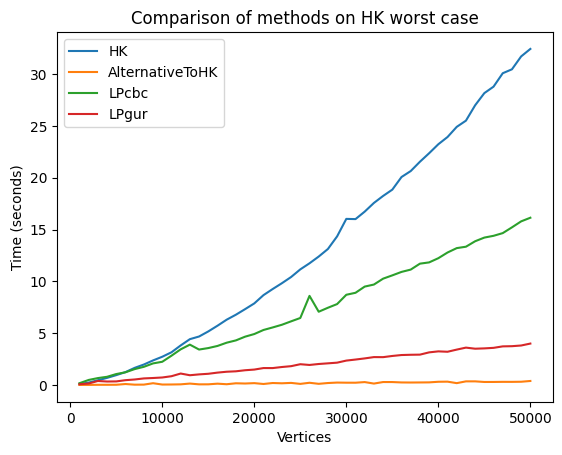

In [8]:
def compareMethodsHKWorst() -> None:
	ns = [i for i in range(1000, 50001, 1000)]
	
	HKTimes = []
	AlternativeToHKTimes = []
	LPcbcTimes = []
	LPgurTimes = []
	
	for n in ns:
		generateHKWorstCase(n, "input")
		
		start_time = time.time()
		HKResult = HK("input")
		end_time = time.time()
		HKTimes.append(end_time - start_time)
		
		start_time = time.time()
		AlternativeToHKResult = AlternativeToHK("input")
		end_time = time.time()
		AlternativeToHKTimes.append(end_time - start_time)
		
		start_time = time.time()
		LPcbcResult = LPcbc("input")
		end_time = time.time()
		LPcbcTimes.append(end_time - start_time)
		
		start_time = time.time()
		LPgurResult = LPgur("input")
		end_time = time.time()
		LPgurTimes.append(end_time - start_time)
		
		assert HKResult == AlternativeToHKResult and AlternativeToHKResult == LPcbcResult and LPcbcResult == LPgurResult
	
	plt.plot(ns, HKTimes, label="HK")
	plt.plot(ns, AlternativeToHKTimes, label="AlternativeToHK")
	plt.plot(ns, LPcbcTimes, label="LPcbc")
	plt.plot(ns, LPgurTimes, label="LPgur")
	plt.xlabel("Vertices")
	plt.ylabel("Time (seconds)")
	plt.title("Comparison of methods on HK worst case")
	plt.legend()
	plt.show()

compareMethodsHKWorst()